

---

# Intro - Autoencoder

**Plan** - produce proof of concept autoencoder architecture.

**Purpose**: dimensionality reduction for input data.

**Hypothesis**: with automatic HP tuning an autoencoder can be used to reduce dimensionality of input data, whilst retaining adequate information to accurately reproduce input data.

**Methodology**: Test on multiple datasets - first the Iris dataset, then Pima Indians, then finally credit card fraud dataset. Evaluate and assess model architecture and visualize latent space using PCA/UMAP etc.


# First dataset - iris dataset
---
## Data sourcing and processing


In [38]:

#import packages :

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  # This is a more robust approach than relying on potentially internal variables.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#table one
!pip install tableone
from tableone import TableOne

#torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#sklearn
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.datasets import load_breast_cancer
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from sklearn.preprocessing import MinMaxScaler



from imblearn.over_sampling import RandomOverSampler

In [24]:
#import data and visualize

# Load the breast cancer dataset
data = load_breast_cancer()

# Convert to Pandas DataFrame
bc_df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target column (malignant or benign)
bc_df['target'] = data.target

bc_columns = bc_df.columns.tolist()

print(f"The dataset lenghth is {str(len(bc_df))}")
print(f"The number of columns is {str(len(bc_columns))}")
print(f"The column names are {str(bc_columns)} \n")

table1 = TableOne(bc_df, columns=bc_columns, groupby= 'target', pval=True)
print(table1)



The dataset lenghth is 569
The number of columns is 31
The column names are ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target'] 

                                    Grouped by target                                                      
                                              Missing        Overall               0              1 P-Value
n                                                                569             212            357        
mean radius,



---

# Autoencoder (Breast cancer dataset)

Cuda setup successful

Best Hyperparameters:
[num encoder layers, num decoder layers, num neurons, activation function, learning rate, batch size, amount of dropout, batchnorm bool]
[1, 2, 128, 'Tanh', 0.01, 64, 0.10547603033127383, False]



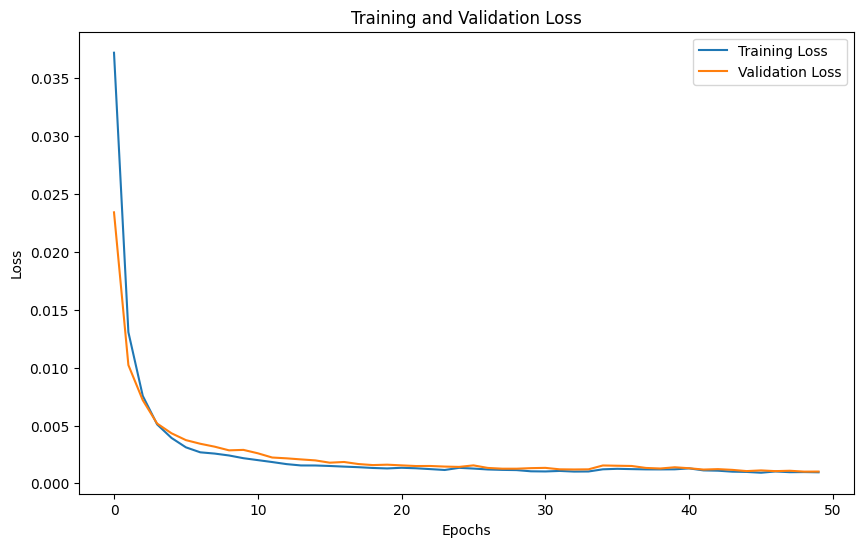

Test Loss: 0.07705461978912354


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Error warning if no GPU is detected**
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")

# Load and preprocess the Breast Cancer dataset
breast_cancer = load_breast_cancer()
data = breast_cancer.data

# Convert to PyTorch Dataset
class BreastCancerDataset(Dataset): # Rename the class
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
data = scaler.fit_transform(data)

dataset = BreastCancerDataset(data) # Use the new dataset class

# Split into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Flexible Autoencoder with Dropout and Batch Normalization

# Flexible Autoencoder with Dropout and Batch Normalization
class FlexibleAutoencoder(nn.Module):
    def __init__(self, input_dim, encoder_layers, decoder_layers, activations, dropout_prob, use_batchnorm):
        super(FlexibleAutoencoder, self).__init__()
        # Build the encoder
        encoder = []
        in_dim = input_dim
        for i in range(len(encoder_layers)):
            encoder.append(nn.Linear(in_dim, encoder_layers[i]))
            if use_batchnorm:
                encoder.append(nn.BatchNorm1d(encoder_layers[i]))
            encoder.append(getattr(nn, activations[i])())
            # Apply dropout if dropout_prob > 0
            if dropout_prob > 0:
                encoder.append(nn.Dropout(dropout_prob))
            in_dim = encoder_layers[i]
        self.encoder = nn.Sequential(*encoder)

        # Build the decoder
        decoder = []
        in_dim = encoder_layers[-1]
        for i in range(len(decoder_layers)):
            # Output layer of decoder should have 'input_dim' units
            out_dim = input_dim if i == len(decoder_layers) - 1 else decoder_layers[i]
            decoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i != len(decoder_layers) - 1:  # No batchnorm on the output layer
                decoder.append(nn.BatchNorm1d(out_dim))
            decoder.append(getattr(nn, activations[len(encoder_layers) + i])())
            # Apply dropout if dropout_prob > 0 and not the output layer
            if dropout_prob > 0 and i != len(decoder_layers) - 1:
                decoder.append(nn.Dropout(dropout_prob))
            in_dim = decoder_layers[i]
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Training and validation function
# Training and validation function
def train_validate_autoencoder(encoder_layers, decoder_layers, activations, lr, batch_size, dropout_prob, use_batchnorm):
    batch_size = int(batch_size)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)

    model = FlexibleAutoencoder(
        input_dim=data.shape[1],
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        activations=activations,
        dropout_prob=dropout_prob,
        use_batchnorm=use_batchnorm
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_epochs = 50
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to device
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    return val_losses[-1], train_losses, val_losses # Return statement added

# Define the search space for Bayesian Optimization
space = [
    Integer(1, 5, name='num_encoder_layers'),
    Integer(1, 5, name='num_decoder_layers'),
    Integer(4, 128, name='num_neurons'),
    Categorical(['ReLU', 'Sigmoid', 'Tanh'], name='activation_fn'),
    Real(1e-4, 1e-2, prior='log-uniform', name='lr'),
    Integer(2, 64, name='batch_size'),  # Min batch size is now 2
    Real(0.0, 0.5, name='dropout_prob'), #dropout probability
    Categorical([True, False], name='use_batchnorm')
]

# Objective function for Bayesian Optimization
@use_named_args(space)  # Use named arguments for clarity
def objective(**params):
    # Extract hyperparameters
    num_encoder_layers = params['num_encoder_layers']
    num_decoder_layers = params['num_decoder_layers']
    num_neurons = params['num_neurons']
    activation_fn = params['activation_fn']
    lr = params['lr']
    batch_size = params['batch_size']
    dropout_prob = params['dropout_prob']  # Access dropout_prob directly
    use_batchnorm = params['use_batchnorm']

    batch_size = int(batch_size)
    encoder_layers = [num_neurons] * num_encoder_layers
    decoder_layers = [num_neurons] * num_decoder_layers
    activations = [activation_fn] * (num_encoder_layers + num_decoder_layers)

    # Call train_validate_autoencoder without use_dropout
    val_loss, _, _ = train_validate_autoencoder(
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        activations=activations,
        lr=lr,
        batch_size=batch_size,
        dropout_prob=dropout_prob,  # Pass dropout_prob directly
        use_batchnorm=use_batchnorm
    )
    return val_loss

# basic Bayesian Optimization
result = gp_minimize(objective, space, n_calls=30, random_state=42)

# Extract best hyperparameters
best_hyperparams = result.x
print(f'''
Best Hyperparameters:
[num encoder layers, num decoder layers, num neurons, activation function, learning rate, batch size, amount of dropout, batchnorm bool]
{best_hyperparams}
''')

# Train the best model and plot losses
best_encoder_layers = [best_hyperparams[2]] * best_hyperparams[0]
best_decoder_layers = [best_hyperparams[2]] * best_hyperparams[1]
best_activations = [best_hyperparams[3]] * (best_hyperparams[0] + best_hyperparams[1])

#call autoencoder
_, train_losses, val_losses = train_validate_autoencoder(
    encoder_layers=best_encoder_layers,
    decoder_layers=best_decoder_layers,
    activations=best_activations,
    lr=best_hyperparams[4],
    batch_size=best_hyperparams[5],
    dropout_prob=best_hyperparams[6], # Pass dropout_prob directly
    use_batchnorm=best_hyperparams[7] # Use index 7 for use_batchnorm
)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loader = DataLoader(test_set, batch_size=min(int(best_hyperparams[5]), len(test_set)), shuffle=False,drop_last=True) # Cast best_hyperparams[5] to int

model = FlexibleAutoencoder(
    input_dim=data.shape[1],
    encoder_layers=best_encoder_layers,
    decoder_layers=best_decoder_layers,
    activations=best_activations,
    dropout_prob=best_hyperparams[6],  # Pass dropout_prob directly
    use_batchnorm=best_hyperparams[7] # Use index 7 for use_batchnorm
).to(device)


model.eval()
test_loss = 0
true_values, predictions = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        loss = nn.MSELoss()(outputs, batch)
        test_loss += loss.item()
        true_values.append(batch.cpu().numpy())
        predictions.append(outputs.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")




---

# Auto push to github




In [43]:
import datetime
import os

def commit_to_github(commit_msg):
  """
  Funct to autopush to github
  """

  # Navigate to the repository directory
  %cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

  # Remove the lock file
  !rm /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice/.git/index.lock

  # Reset and stage changes
  !git reset
  !git add .

  with open('/content/drive/MyDrive/IAM/PAT.txt', 'r') as file:
        github_pat = file.read().strip()
  os.environ['GITHUB_PAT'] = github_pat

  !git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

  # Replace with your actual username and email
  USERNAME="archiegoodman2"
  EMAIL="archiegoodman2011@gmail.com"

  # Set global username and email configuration
  !git config --global user.name "$USERNAME"
  !git config --global user.email "$EMAIL"

  now = datetime.datetime.now()
  current_datetime = now.strftime("%Y-%m-%d %H:%M")

  # Set remote URL using the PAT from environment variable
  !git remote set-url origin https://{os.environ['GITHUB_PAT']}@github.com/archiegoodman2/machine_learning_practice.git

  # Replace with your desired commit message
  COMMIT_MESSAGE = str(current_datetime) + str(commit_msg)

  # Commit the changes
  !git commit -m "$COMMIT_MESSAGE"

  # Push to origin (force push if necessary)
  !git push -f origin master

  return 1

commit_to_github("Added normalization before inputting data to encoder")


/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice
rm: cannot remove '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice/.git/index.lock': No such file or directory
error: remote origin already exists.
On branch master
nothing to commit, working tree clean
Everything up-to-date


1